In [1]:
import pandas as pd

In [2]:
import numpy as np
import pandas as pd

np.random.seed(42)

ROWS = 12000

data = {
    # Demographics
    "age": np.random.randint(25, 85, ROWS),
    "sex": np.random.binomial(1, 0.55, ROWS),  # 55% male
    
    # Clinical measurements
    "cholesterol": np.random.normal(240, 50, ROWS),
    "resting_bp": np.random.normal(135, 20, ROWS),
    "max_heart_rate": np.random.normal(150, 25, ROWS),
    
    # Blood indicators
    "fasting_blood_sugar": np.random.binomial(1, 0.25, ROWS),
    "blood_sugar_level": np.random.normal(110, 30, ROWS),
    
    # Symptoms
    "exercise_angina": np.random.binomial(1, 0.3, ROWS),
    "oldpeak": np.abs(np.random.normal(1.5, 1.2, ROWS)),
    
    # Lifestyle / history
    "smoking": np.random.binomial(1, 0.35, ROWS),
    "obesity": np.random.binomial(1, 0.4, ROWS),
}

df = pd.DataFrame(data)

# --- Introduce medical realism ---
df["cholesterol"] = df["cholesterol"].clip(120, 450)
df["resting_bp"] = df["resting_bp"].clip(80, 200)
df["max_heart_rate"] = df["max_heart_rate"].clip(60, 210)
df["blood_sugar_level"] = df["blood_sugar_level"].clip(60, 300)
df["oldpeak"] = df["oldpeak"].clip(0, 6)

# --- Disease probability logic (REALISTIC) ---
risk_score = (
    0.03 * df["age"] +
    0.02 * df["cholesterol"] +
    0.025 * df["resting_bp"] +
    0.04 * df["fasting_blood_sugar"] * 100 +
    0.05 * df["exercise_angina"] * 100 +
    0.04 * df["smoking"] * 100 +
    0.04 * df["obesity"] * 100 +
    0.03 * df["oldpeak"] * 10 -
    0.02 * df["max_heart_rate"]
)

probability = 1 / (1 + np.exp(-0.03 * (risk_score - risk_score.mean())))

df["target"] = (probability > 0.65).astype(int)

# --- Enforce class imbalance (industry realistic) ---
# ~80% healthy, ~20% disease
df.loc[df.sample(frac=0.25, random_state=42).index, "target"] = 0

# --- Inject missing values (noise) ---
for col in ["cholesterol", "resting_bp", "blood_sugar_level"]:
    df.loc[df.sample(frac=0.07, random_state=42).index, col] = np.nan

# --- Inject impossible values (dirty hospital data) ---
df.loc[df.sample(frac=0.01, random_state=42).index, "cholesterol"] = 0
df.loc[df.sample(frac=0.01, random_state=24).index, "resting_bp"] = 0

print(df.head())
print("\nShape:", df.shape)
print("\nTarget distribution:\n", df["target"].value_counts(normalize=True))




risk = (
    (df["cholesterol"] > 240).astype(int) +
    (df["resting_bp"] > 140).astype(int) +
    df["exercise_angina"] +
    df["smoking"] +
    df["obesity"] +
    (df["age"] > 55).astype(int)
)

df["target"] = (risk >= 3).astype(int)


   age  sex  cholesterol  resting_bp  max_heart_rate  fasting_blood_sugar  \
0   63    1   158.236706  171.826261      181.703149                    0   
1   76    1   307.802317  143.901204      126.261537                    0   
2   53    1   292.632469  159.715218      150.652781                    0   
3   39    1   216.365781  147.477747      191.136913                    0   
4   67    0   253.091766  126.739457      140.254895                    0   

   blood_sugar_level  exercise_angina   oldpeak  smoking  obesity  target  
0         177.554990                0  2.217908        1        1       0  
1          83.504048                1  1.480675        0        0       0  
2         112.736859                0  0.072005        1        0       0  
3         149.440470                0  2.377410        0        0       0  
4         109.788175                1  2.550232        0        0       0  

Shape: (12000, 12)

Target distribution:
 target
0    1.0
Name: proportion, dtyp

In [4]:
df

,age,sex,cholesterol,resting_bp,max_heart_rate,fasting_blood_sugar,blood_sugar_level,exercise_angina,oldpeak,smoking,obesity,target
0,63,1,158.236706,171.826261,181.703149,0,177.554990,0,2.217908,1,1,1
1,76,1,307.802317,143.901204,126.261537,0,83.504048,1,1.480675,0,0,1
2,53,1,292.632469,159.715218,150.652781,0,112.736859,0,0.072005,1,0,1
3,39,1,216.365781,147.477747,191.136913,0,149.440470,0,2.377410,0,0,0
4,67,0,253.091766,126.739457,140.254895,0,109.788175,1,2.550232,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
11995,57,1,NaN,NaN,166.054175,0,NaN,0,0.757018,1,1,1
11996,70,0,178.429561,123.167288,149.343325,1,107.229654,0,2.060941,0,0,0
11997,41,1,218.337595,152.408872,169.674321,0,150.730573,0,0.663092,1,0,0
11998,66,1,NaN,NaN,182.172033,0,NaN,0,0.956816,1,0,0


INFO REGARDING COLUMNS AND THE PROBLEMS OUT THERE 

In [5]:
df['resting_bp'].isnull().sum()

np.int64(828)

In [6]:
df['max_heart_rate'].isnull().sum()

np.int64(0)

In [7]:
df.groupby('age')['max_heart_rate'].mean().head(3)

,max_heart_rate
age,
25,151.000520
26,155.199743
27,147.240147


In [8]:
a=76
b=220
print(b-a)

144


In [9]:
df['max_heart_rate'].mean()

np.float64(150.1185822994977)

In [10]:
df.head(3)

,age,sex,cholesterol,resting_bp,max_heart_rate,fasting_blood_sugar,blood_sugar_level,exercise_angina,oldpeak,smoking,obesity,target
0,63,1,158.236706,171.826261,181.703149,0,177.554990,0,2.217908,1,1,1
1,76,1,307.802317,143.901204,126.261537,0,83.504048,1,1.480675,0,0,1
2,53,1,292.632469,159.715218,150.652781,0,112.736859,0,0.072005,1,0,1


In [11]:
df['fasting_blood_sugar']

,fasting_blood_sugar
0,0
1,0
2,0
3,0
4,0
...,...
11995,0
11996,1
11997,0
11998,0


In [5]:
df['blood_sugar_level'].describe()

,blood_sugar_level
count,11160.000000
mean,110.828335
std,28.651636
min,60.000000
25%,90.064954
50%,110.284368
75%,130.602663
max,227.482298


In [11]:
df[df['fasting_blood_sugar'] == 0]

,age,sex,cholesterol,resting_bp,max_heart_rate,fasting_blood_sugar,blood_sugar_level,exercise_angina,oldpeak,smoking,obesity,target
0,63,1,158.236706,171.826261,181.703149,0,177.554990,0,2.217908,1,1,1
1,76,1,307.802317,143.901204,126.261537,0,83.504048,1,1.480675,0,0,1
2,53,1,292.632469,159.715218,150.652781,0,112.736859,0,0.072005,1,0,1
3,39,1,216.365781,147.477747,191.136913,0,149.440470,0,2.377410,0,0,0
4,67,0,253.091766,126.739457,140.254895,0,109.788175,1,2.550232,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
11992,41,1,244.499322,139.628526,133.571846,0,64.670958,0,1.553839,1,0,0
11994,51,0,217.618827,166.631437,158.215770,0,86.078973,0,3.248811,1,0,0
11995,57,1,NaN,NaN,166.054175,0,NaN,0,0.757018,1,1,1
11997,41,1,218.337595,152.408872,169.674321,0,150.730573,0,0.663092,1,0,0


In [14]:
df[df['blood_sugar_level'] == 0].shape


(0, 12)

In [18]:
df['exercise_angina']

,exercise_angina
0,0
1,1
2,0
3,0
4,1
...,...
11995,0
11996,0
11997,0
11998,0


In [26]:
df.head()

,age,sex,cholesterol,resting_bp,max_heart_rate,fasting_blood_sugar,blood_sugar_level,exercise_angina,oldpeak,smoking,obesity,target
0,63,1,158.236706,171.826261,181.703149,0,177.554990,0,2.217908,1,1,1
1,76,1,307.802317,143.901204,126.261537,0,83.504048,1,1.480675,0,0,1
2,53,1,292.632469,159.715218,150.652781,0,112.736859,0,0.072005,1,0,1
3,39,1,216.365781,147.477747,191.136913,0,149.440470,0,2.377410,0,0,0
4,67,0,253.091766,126.739457,140.254895,0,109.788175,1,2.550232,0,0,1


<Axes: xlabel='oldpeak'>

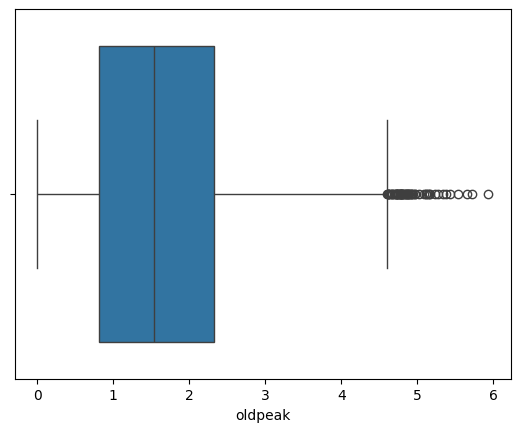

In [49]:

import seaborn as sns
sns.boxplot(x=df['oldpeak'])

In [27]:
df.corr()

,age,sex,cholesterol,resting_bp,max_heart_rate,fasting_blood_sugar,blood_sugar_level,exercise_angina,oldpeak,smoking,obesity,target
age,1.000000,0.025788,0.000852,0.010220,-0.004688,0.005184,-0.005175,-0.013373,-0.011172,-0.004094,0.008031,0.302618
sex,0.025788,1.000000,0.009356,0.009545,-0.011300,0.016990,-0.003234,-0.004199,-0.020772,-0.001498,-0.018083,0.004263
cholesterol,0.000852,0.009356,1.000000,0.007422,0.010030,0.007980,-0.006977,0.002987,0.009059,-0.000278,0.002703,0.285215
resting_bp,0.010220,0.009545,0.007422,1.000000,-0.019063,-0.016700,0.014685,-0.014732,-0.016901,0.002610,0.001015,0.239732
max_heart_rate,-0.004688,-0.011300,0.010030,-0.019063,1.000000,-0.011053,0.016772,-0.008724,0.000069,0.003348,0.000262,0.000385
fasting_blood_sugar,0.005184,0.016990,0.007980,-0.016700,-0.011053,1.000000,-0.000827,-0.019992,-0.010745,-0.012022,-0.001469,-0.015542
blood_sugar_level,-0.005175,-0.003234,-0.006977,0.014685,0.016772,-0.000827,1.000000,-0.001706,-0.002610,-0.004828,-0.002995,-0.006729
exercise_angina,-0.013373,-0.004199,0.002987,-0.014732,-0.008724,-0.019992,-0.001706,1.000000,0.001306,0.003486,0.008652,0.313026
oldpeak,-0.011172,-0.020772,0.009059,-0.016901,0.000069,-0.010745,-0.002610,0.001306,1.000000,0.007993,0.004299,-0.001004
smoking,-0.004094,-0.001498,-0.000278,0.002610,0.003348,-0.012022,-0.004828,0.003486,0.007993,1.000000,-0.004336,0.324921
